In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from tqdm import tqdm

COMP_DIR = "completion"
OUT_DIR = "eval"
os.makedirs(OUT_DIR, exist_ok=True)

In [2]:
# Load completion outputs
def load_completion(tag):
    data = []
    with open(os.path.join(COMP_DIR, f"{tag}.jsonl"), "r", encoding="utf-8") as f:
        for line in f:
            j = json.loads(line)
            for s in j["sentences"]:
                data.append({
                    "pmid": j["pmid"],
                    "id": s["id"],
                    "original": s["original"],
                    "resolved": s["resolved"],
                    "model": tag
                })
    return pd.DataFrame(data)

In [3]:
# Evaluation functions
def is_single_clause(text):
    return text.count(" and ") <= 1 and text.count(" or ") == 0 and "," not in text

def simple_grammar_check(text):
    tokens = text.split()
    return len(tokens) >= 4 and text[0].isupper() and text.endswith(".")

def evaluate_structure(df):
    df["len"] = df["resolved"].str.split().map(len)
    df["is_single"] = df["resolved"].map(is_single_clause)
    df["is_well_formed"] = df["resolved"].map(simple_grammar_check)
    return df

In [4]:
# Load all models and evaluate
all_dfs = []
for model in ["gpt4o", "claude", "llama"]:
    df = load_completion(model)
    df = evaluate_structure(df)
    all_dfs.append(df)

df_all = pd.concat(all_dfs, ignore_index=True)
df_all.to_csv(f"{OUT_DIR}/completion_full.csv", index=False)

In [5]:
# Summary stats
summary = df_all.groupby("model").agg({
    "resolved": "count",
    "is_single": "mean",
    "is_well_formed": "mean",
    "len": ["mean", "std"]
}).round(2)
summary.columns = ["Total", "%SingleClause", "%WellFormed", "AvgLen", "StdLen"]
summary.to_csv(f"{OUT_DIR}/completion_summary.csv")
print("\n=== Completion Summary ===")
print(summary)


=== Completion Summary ===
        Total  %SingleClause  %WellFormed  AvgLen  StdLen
model                                                    
claude    361           0.42         0.99   22.83    9.97
gpt4o     305           0.73         1.00   17.21    7.97
llama     357           0.85         0.98   12.87    5.26


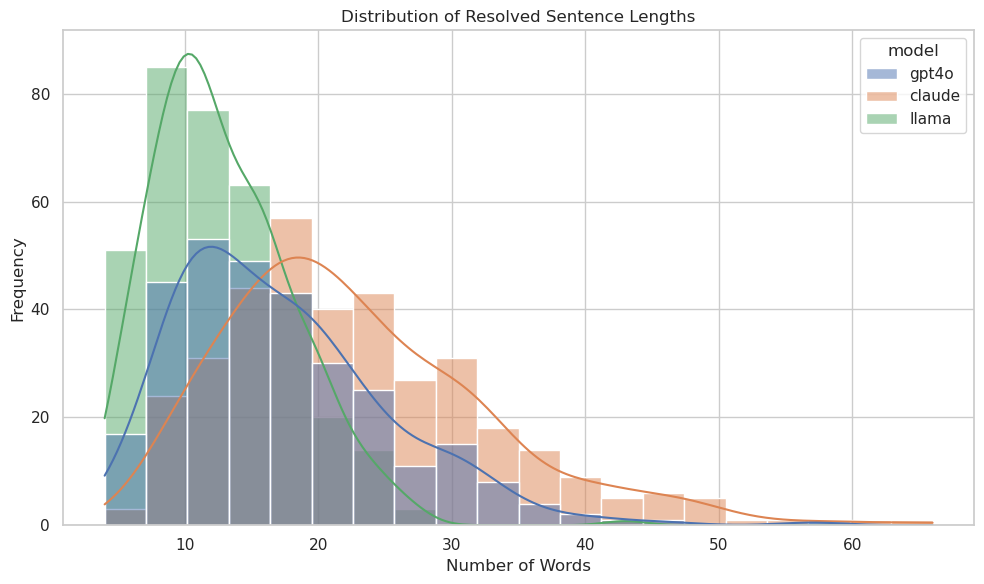

In [6]:
# Plot sentence length distribution
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df_all, x="len", hue="model", bins=20, kde=True)
plt.title("Distribution of Resolved Sentence Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/completion_len_dist.png")
plt.show()

In [7]:
# horizontal comparison
df_grouped = (
    df_all.groupby(["pmid", "id", "model"])["resolved"]
          .apply(lambda x: " ||| ".join(x))
          .reset_index()
)
df_wide = df_grouped.pivot(index=["pmid", "id"], columns="model", values="resolved").reset_index()
df_wide.to_csv(f"{OUT_DIR}/completion_wide_comparison.csv", index=False)

print("\nSaved evaluation results to eval/*.csv and eval/*.png")


Saved evaluation results to eval/*.csv and eval/*.png
